In [1]:
import bz2
import os

from urllib.request import urlopen

# Down face landmarks.dat
def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [2]:
import pickle
import numpy as np

with open('data_test/test_1/x_label.pkl', 'rb') as f:
    x_label = np.array(pickle.load(f))
with open('data_test/test_1/y_label.pkl', 'rb') as f:
    y_label = np.array(pickle.load(f))
with open('data_test/test_1/x_vector.pkl', 'rb') as f:
    x_vector = np.array(pickle.load(f))
with open('data_test/test_1/y_vector.pkl', 'rb') as f:
    y_vector = np.array(pickle.load(f))

In [3]:
z_vector = np.append(x_vector, y_vector, axis=0)
z_label = np.append(x_label, y_label)

print (x_vector.shape, y_vector.shape)
print (x_label.shape, y_label.shape)
print (z_vector.shape, z_label.shape)
print (np.max(z_label))

(605, 128) (6088, 128)
(605,) (6088,)
(6693, 128) (6693,)
604


In [4]:
count = np.zeros(605)
for i, lb in enumerate(z_label):
    count[lb] += 1

In [5]:
# Chọn những người có số lượng ảnh >= 12 
vector = np.reshape(np.array([]), (-1, 128))
label = (np.array([])).astype(int)

for i, lb in enumerate(z_label):
    if (count[lb] >= 12):
        vector = np.append(vector, np.reshape(z_vector[i], (-1, 128)), axis=0)
        label = np.append(label, z_label[i])
print (vector.shape, label.shape)

(3986, 128) (3986,)


In [6]:
print (len(np.unique(label)))

127


In [7]:
# Lấy 10 người để train, số còn lại dùng để test

X_train = np.reshape(np.array([]), (-1, 128))
X_test = np.reshape(np.array([]), (-1, 128))
y_train = np.array([])
y_test = np.array([])
count = np.zeros(605)

for i, lb in enumerate(label):
    if count[lb] < 10:
        X_train = np.append(X_train, np.reshape(vector[i], (-1, 128)), axis=0)
        y_train = np.append(y_train, label[i])
    else :
        X_test = np.append(X_test, np.reshape(vector[i], (-1, 128)), axis=0)
        y_test = np.append(y_test, label[i])
    count[lb] += 1

In [8]:
# Shuffle tập train
idx = np.random.permutation(len(y_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=5, metric = 'euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print (acc_knn, acc_svc)

0.8409425625920471 0.8799705449189985


In [63]:
def distance_svm(X):
    return svc.decision_function(X)

In [86]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

distances = np.array([]) # Khoảng cách 2 ảnh
identical = np.array([]) # 1 nếu cùng 1 người, ngược lại là 0 

num = len(y_test)

for i in tqdm(range(num)):
        vc = np.reshape(X_test[i],(1, -1))
        distances = np.append(distances, distance_svm(vc))
        for j in svc.classes_:
            identical = np.append(identical, 1 if y_test[i] == j else 0)

100%|██████████| 2716/2716 [00:43<00:00, 24.91it/s]


In [87]:
print (distances)
print (identical)

[ 0.14653182 -1.98686451 -1.97829273 ... -1.98636419 -2.0237361
  0.73636877]
[1. 0. 0. ... 0. 0. 1.]


In [119]:
thresholds = np.arange(-2, 2, 0.04)

f1_scores = [f1_score(identical, distances > t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances > t) for t in thresholds]


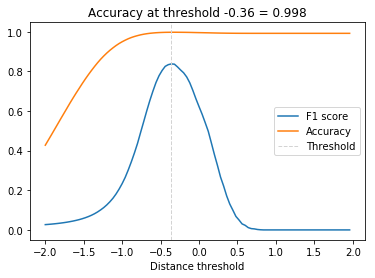

In [120]:
from matplotlib import pyplot as plt
opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances > opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();